# Calculo de la distribucion de tiempos en comun

En este notebook se genera un informe sobre la distribucion de tiempos
en comun que pueden tener las observaciones hermanas.

Consideraciones:

- Nos interesa los tiempos relativos a la observacion. Por eso se usa los MJD
- Dado que los MJD son unicos al pawprint para lograr mayor eficiencia de computo
  se utilizan los ID de los pawprint para contar

In [1]:
import sys
import os
import gc
import itertools as it
import tempfile
from collections import Counter, namedtuple
import multiprocessing as mp
import datetime as dt


import numpy as np
import pandas as pd

from joblib import Parallel, delayed, cpu_count, load, dump, Memory

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# corral startup
sys.path.insert(1, "/home/jbcabral/carpyncho3")
os.environ.setdefault("CORRAL_SETTINGS_MODULE", "carpyncho.settings")

from corral import core
core.setup_environment()

from corral import db
from carpyncho.models import LightCurves

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
with db.session_scope() as session:
    lc = session.query(LightCurves).filter(LightCurves.tile.has(name="b396")).one()
    obs_counter = lc.obs_counter
    observations = lc.observations

[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,940] select version()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,942] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,946] select current_schema()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,949] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,953] SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,954] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,957] SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,959] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,963] show standard_conforming_strings
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,965] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-10-14 14:04:48,969] BEGIN (imp

395


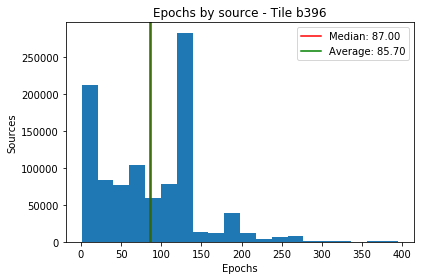

In [18]:
print np.max(obs_counter["cnt"])
median = np.percentile(obs_counter["cnt"], 50)
mean = np.mean(obs_counter["cnt"])
ax = plt.gca()
ax.hist(obs_counter["cnt"], bins=20);
ax.axvline(median, color="r", label="Median: {:.2f}".format(median))
ax.axvline(mean, color="g", label="Average: {:.2f}".format(mean))
ax.set_title("Epochs by source - Tile b396")
ax.set_ylabel("Sources")
ax.set_xlabel("Epochs")
ax.legend()
plt.tight_layout()
plt.savefig("figs/epochs_b396.pdf", bbox_inches='tight')

In [27]:
obs_min = np.random.choice(
    obs_counter[obs_counter["cnt"] >= 87]["id"], 5000, False)

df = pd.DataFrame(observations[['bm_src_id', u'pwp_id']])
df = df[df.bm_src_id.isin(obs_min)]

In [28]:
%time groups = df.groupby("bm_src_id")

CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 628 µs


In [29]:
temp_folder = "./cache"
filename = os.path.join(temp_folder, 'groups.mmap')
dump(groups, filename)
groups = load(filename, mmap_mode='r+')

In [30]:
%time combinations = tuple(it.combinations(obs_min, 2))

CPU times: user 16.3 s, sys: 2.12 s, total: 18.5 s
Wall time: 18.5 s


In [31]:
%time split_combs = np.array_split(combinations, 100)

CPU times: user 10.3 s, sys: 39 ms, total: 10.4 s
Wall time: 10.4 s


In [5]:
Best = namedtuple("Best", ["src_1", "src_2", "n_1", "n_2", "mmjd_1", "mmjd_2", "mmjd_diff"])

class NbgCalc(mp.Process):
    
    def __init__(self, idx, total, combs, groups):
        super(NbgCalc, self).__init__()
        self.idx = idx
        self.total = total
        self.combs = combs
        self.groups = groups
        self.size = len(combs)
        self._cache = {}
        self.queue = mp.Queue()
        
    def get_group(self, k):
        if k not in self._cache:
            self._cache[k] = frozenset(self.groups.get_group(k)["pwp_id"].values)
        return self._cache[k]
        
    def run(self):
        start = dt.datetime.now()
        print("[{}] Starting {}/{} with {} combs".format(
            start, self.idx, self.total, self.size))
        cnt = Counter()
        for k1, k2 in self.combs:
            g1, g2 = self.get_group(k1), self.get_group(k2)
            intersection = len(g1.intersection(g2))
            cnt.update([intersection])
        end = dt.datetime.now()
        
        print("[{}] Done {}/{}".format(end, self.idx, self.total))
        
        values_sum = sum(cnt.values())
        if values_sum != self.size:
            ex = ValueError("Combs {}/{} with diferent result sizes {} != {}".format(
                self.idx, self.total, self.size, values_sum))
            self.queue.put(ex)
        else:
            self.queue.put(cnt)
        
    def result(self):
        return self.queue.get()

def serialize(combs_chunks):
    serialized, total = [], len(combs_chunks)
    for idx, combs in enumerate(combs_chunks):
        combs = np.array(list(combs))
        fname = 'combs_{}.mmap'.format(idx)
        filename = os.path.join(temp_folder, fname)
        dump(combs, filename)
        combs = load(filename, mmap_mode='r+')
        print("[{}] {}/{} serialized".format(dt.datetime.now(), idx, total))
        yield idx, combs
    
total = cpu_count()
results, lens = [], []
for comb_group in split_combs:
    procs = []
    for idx, for_cpu in enumerate(np.array_split(comb_group, total)):
        lens.append(len(for_cpu))
        proc = NbgCalc(idx=idx, combs=for_cpu, total=total, groups=groups)
        proc.start()
        procs.append(proc)
    for proc in procs:
        proc.join()
        presult = proc.result()
        results.append(presult)
    del procs

NameError: name 'split_combs' is not defined

In [ ]:
# grouped_chunks = np.array_split(it.tee(it.combinations(obs_min, 2), total), 10)

# partial = []
# for combs_chunks in grouped_chunks:
#     procs = []
#     for idx, combs in serialize(combs_chunks):
#         proc = NbgCalc(idx, len(combs_chunks), combs, groups)
#         proc.start()
#         procs.append(proc)
#     for proc in procs:
#         proc.join()
#         partial.append(proc.result())
#     del procs, combs
#     gc.collect()

# del combs_chunks
# gc.collect()

### Store the result to continue in another notebook

In [33]:
import pickle
with open("./data/count.pkl", "w") as fp:
    pickle.dump(results, fp)